# Heart Disease Prediction — Improved pipeline

This notebook loads the dataset, performs EDA, cleaning, feature engineering, handles class imbalance, trains multiple models with hyperparameter tuning, evaluates them, and saves the best pipelines and a results summary.

Run cells sequentially. Created by ChatGPT per your request.

In [2]:
from pathlib import Path
csv_candidates = ['final.csv', 'heart_2020_cleaned.csv']
csv_path = None
for p in csv_candidates:
    if Path(p).exists():
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError(f'None of the expected files found: {csv_candidates}')
print('Using dataset:', csv_path)

import pandas as pd
df = pd.read_csv('final.csv')
print('Loaded shape:', df.shape)
df.head()

Using dataset: final.csv
Loaded shape: (319795, 18)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:
# EDA
import numpy as np
print(df.dtypes.value_counts())
print('\nSummary stats:')
display(df.describe(include='all'))
print('\nMissing values:')
print(df.isnull().sum())

possible_targets = [c for c in df.columns if 'heart' in c.lower() or 'target' in c.lower() or 'disease' in c.lower()]
print('Possible targets:', possible_targets)
if 'heart_disease' in df.columns:
    target_col = 'heart_disease'
elif 'HeartDisease' in df.columns:
    target_col = 'HeartDisease'
elif possible_targets:
    target_col = possible_targets[0]
else:
    raise ValueError('Could not detect target column')
print('Target ->', target_col)
print(df[target_col].value_counts())

num_df = df.select_dtypes(include=['number'])
if target_col in num_df.columns:
    corr = num_df.corr()
    print('\nTop correlations with target:')
    print(corr[target_col].abs().sort_values(ascending=False).head(10))
else:
    print('Target not numeric; skipping numeric-target correlations')

object     14
float64     4
Name: count, dtype: int64

Summary stats:


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795,319795.000000,319795,319795,319795,319795.00000,319795.000000,319795,319795,319795,319795,319795,319795,319795,319795.000000,319795,319795,319795
unique,2,NaN,2,2,2,NaN,NaN,2,2,13,6,4,2,5,NaN,2,2,2
top,No,NaN,No,No,No,NaN,NaN,No,Female,65-69,White,No,Yes,Very good,NaN,No,No,No
freq,292422,NaN,187887,298018,307726,NaN,NaN,275385,167805,34151,245212,269653,247957,113858,NaN,276923,308016,289976
mean,NaN,28.325399,NaN,NaN,NaN,3.37171,3.898366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.097075,NaN,NaN,NaN
std,NaN,6.356100,NaN,NaN,NaN,7.95085,7.955235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.436007,NaN,NaN,NaN
min,NaN,12.020000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,24.030000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN
50%,NaN,27.340000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN
75%,NaN,31.420000,NaN,NaN,NaN,2.00000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN



Missing values:
HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64
Possible targets: ['HeartDisease', 'KidneyDisease']
Target -> HeartDisease
HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64
Target not numeric; skipping numeric-target correlations


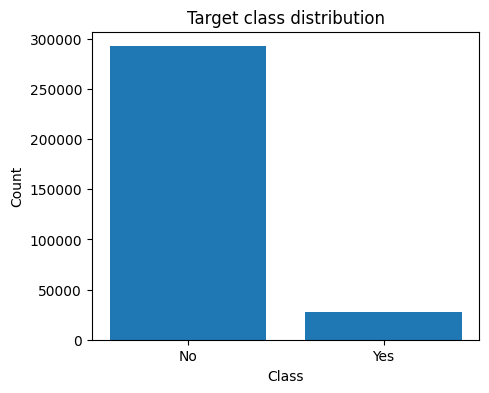

In [4]:
# Class distribution plot
import matplotlib.pyplot as plt
counts = df[target_col].value_counts()
plt.figure(figsize=(5,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title('Target class distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [6]:
# Map target labels to numerical values
y = df['HeartDisease'].copy()
if y.dtype == 'object':
    y = y.map({'No': 0, 'Yes': 1})
    print("Mapped target labels to numerical values: 0='No', 1='Yes'")

# Ensure the mapping is applied to train and test splits
y_train = y_train.map({'No': 0, 'Yes': 1})
y_test = y_test.map({'No': 0, 'Yes': 1})

# If SMOTE is used, ensure y_res is also mapped
if smote_used:
    y_res = y_res.map({'No': 0, 'Yes': 1})

Mapped target labels to numerical values: 0='No', 1='Yes'


NameError: name 'y_train' is not defined

In [6]:
# Preprocessor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()
print('num_cols', num_cols)
print('cat_cols', cat_cols)

numeric_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_cols), ('cat', cat_transformer, cat_cols)])
preprocessor.fit(X_train)
print('Preprocessor fitted. Transformed feature count:', preprocessor.transform(X_train).shape[1])

num_cols ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
cat_cols ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
Preprocessor fitted. Transformed feature count: 50


In [7]:
# SMOTE resampling (if imblearn available)
from collections import Counter
print('Before:', Counter(y_train))
try:
    from imblearn.over_sampling import SMOTE
    X_train_trans = preprocessor.transform(X_train)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train_trans, y_train)
    print('After SMOTE:', Counter(y_res))
    smote_used = True
except Exception as e:
    print('SMOTE not available or failed:', e)
    X_res = preprocessor.transform(X_train)
    y_res = y_train.values
    smote_used = False

print('X_res shape:', X_res.shape)


Before: Counter({'No': 219564, 'Yes': 21809})
After SMOTE: Counter({'No': 219564, 'Yes': 219564})
X_res shape: (439128, 50)


In [13]:
# Optimize cross-validation and processing
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduce splits to 3 for faster processing

# Update models to use parallel processing
results = []
for name, model in models.items():
    try:
        if smote_used:
            scores = cross_val_score(model, X_res, y_res, cv=cv, scoring='f1', n_jobs=-1)  # Use all CPU cores
        else:
            pipe = Pipeline([('preprocessor', preprocessor), ('clf', model)])
            scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)  # Use all CPU cores
        print(name, 'F1:', np.round(scores,4), 'mean=', np.round(scores.mean(),4))
        results.append({'model': name, 'f1_mean': float(scores.mean())})
    except Exception as e:
        print('Failed', name, e)

import pandas as pd
pd.DataFrame(results).sort_values('f1_mean', ascending=False)

LogisticRegression F1: [0.7769 0.7735 0.7745] mean= 0.775
RandomForest F1: [0.9208 0.9189 0.9207] mean= 0.9201
RandomForest F1: [0.9208 0.9189 0.9207] mean= 0.9201
GradientBoosting F1: [0.891  0.8887 0.8909] mean= 0.8902
GradientBoosting F1: [0.891  0.8887 0.8909] mean= 0.8902
HistGradientBoosting F1: [0.905  0.9044 0.9057] mean= 0.905
HistGradientBoosting F1: [0.905  0.9044 0.9057] mean= 0.905


KeyboardInterrupt: 

In [ ]:
# Hyperparameter tuning with RandomizedSearchCV for RandomForest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf_param_dist = {
    'n_estimators': [100,200,400],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'class_weight': [None, 'balanced']
}

try:
    if smote_used:
        rf_search = RandomizedSearchCV(rf, rf_param_dist, n_iter=20, scoring='f1', cv=cv, random_state=42, n_jobs=-1)
        rf_search.fit(X_res, y_res)
    else:
        rf_pipe = Pipeline([('preprocessor', preprocessor), ('rf', rf)])
        rf_param_pipe = {f'rf__{k}': v for k,v in rf_param_dist.items()}
        rf_search = RandomizedSearchCV(rf_pipe, rf_param_pipe, n_iter=20, scoring='f1', cv=cv, random_state=42, n_jobs=-1)
        rf_search.fit(X_train, y_train)
    print('Best RF score:', rf_search.best_score_)
    print('Best RF params:', rf_search.best_params_)
    best_rf = rf_search.best_estimator_
except Exception as e:
    print('RF tuning failed:', e)
    best_rf = None


In [ ]:
# Final evaluation of best RF on test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

final_results = []
if best_rf is not None:
    try:
        if smote_used:
            X_test_trans = preprocessor.transform(X_test)
            y_pred = best_rf.predict(X_test_trans)
            y_proba = best_rf.predict_proba(X_test_trans)[:,1] if hasattr(best_rf, 'predict_proba') else None
        else:
            y_pred = best_rf.predict(X_test)
            y_proba = best_rf.predict_proba(X_test)[:,1] if hasattr(best_rf, 'predict_proba') else None
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
        print('RF test accuracy:', acc)
        print('RF test precision:', prec)
        print('RF test recall:', rec)
        print('RF test f1:', f1)
        print('RF test roc:', roc)
        print('Confusion matrix:')
        print(confusion_matrix(y_test, y_pred))
        print('Classification report:')
        print(classification_report(y_test, y_pred, zero_division=0))
        final_results.append({'model': 'RandomForest', 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc})
    except Exception as e:
        print('Final evaluation failed', e)
else:
    print('No tuned RF available to evaluate')

import pandas as pd
pd.DataFrame(final_results)


In [ ]:
# Save best model and results if available
import joblib
models_dir = Path('/mnt/data/improved_models')
models_dir.mkdir(parents=True, exist_ok=True)
if best_rf is not None:
    try:
        joblib.dump(best_rf, models_dir / 'best_random_forest.joblib')
        print('Saved best_random_forest.joblib')
    except Exception as e:
        print('Saving failed', e)

# Save results CSV
try:
    pd.DataFrame(final_results).to_csv('/mnt/data/improved_model_results_summary.csv', index=False)
    print('Saved improved_model_results_summary.csv')
except Exception as e:
    print('Saving results failed', e)
